# Clasificador de imágenes

In [1]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import np_utils
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt

# Configuración de parámetros

In [2]:
#Dimensiones de las imagenes, dado que la arquitectura del modelo preentrenado usa estas dimeniones VGG16
width_shape = 224
height_shape = 224
#Cantidad de clasificaciones
num_classes = 12
#Epocas y tamaño de muestras
epochs = 50
batch_size = 64 

# Path de dataset

In [5]:
train_data_dir_presize = 'D:/Users/maick/Desktop/Tesis/TL/Fruits/train_presize'   
validation_data_dir_presize = 'D:/Users/maick/Desktop/Tesis/TL/Fruits/test_presize'

train_data_dir='D:/Users/maick/Desktop/Tesis/TL/Fruits/train'
validation_data_dir= 'D:/Users/maick/Desktop/Tesis/TL/Fruits/test'

# redimesionamiento y conteo


In [4]:
total_images_train = 0
total_images_test = 0
target_size = (224, 224)

#Root=ruta hasta el directorio, dirs= lista de carpetas, files =lista de archivos en cada carpetas

#train
for root, dirs, files in os.walk(train_data_dir_presize):
   for name in files:
        image_path = os.path.join(root, name)
        image = cv2.imread(image_path)

        # Redimensionar la imagen
        resized_image = cv2.resize(image, target_size)
        
        # Guardar la imagen redimensionada en el directorio de salida
        
        out= os.path.join(root, name).replace("/", "\\")
        print(out.replace("_presize",""))
        cv2.imwrite(out.replace("_presize",""), resized_image)

#Test
for root, dirs, files in os.walk(validation_data_dir_presize):
   for name in files:
        image_path = os.path.join(root, name)
        image = cv2.imread(image_path)

        # Redimensionar la imagen
        resized_image = cv2.resize(image, target_size)
        
        # Guardar la imagen redimensionada en el directorio de salida
        
        out= os.path.join(root, name).replace("/", "\\")
        print(out.replace("_presize",""))
        cv2.imwrite(out.replace("_presize",""), resized_image)    


D:\Users\maick\Desktop\Tesis\TL\Fruits\train\Apple Braeburn\Apple Braeburn_10.jpg
D:\Users\maick\Desktop\Tesis\TL\Fruits\train\Apple Braeburn\Apple Braeburn_100.jpg
D:\Users\maick\Desktop\Tesis\TL\Fruits\train\Apple Braeburn\Apple Braeburn_101.jpg
D:\Users\maick\Desktop\Tesis\TL\Fruits\train\Apple Braeburn\Apple Braeburn_102.jpg
D:\Users\maick\Desktop\Tesis\TL\Fruits\train\Apple Braeburn\Apple Braeburn_103.jpg
D:\Users\maick\Desktop\Tesis\TL\Fruits\train\Apple Braeburn\Apple Braeburn_105.jpg
D:\Users\maick\Desktop\Tesis\TL\Fruits\train\Apple Braeburn\Apple Braeburn_106.jpg
D:\Users\maick\Desktop\Tesis\TL\Fruits\train\Apple Braeburn\Apple Braeburn_107.jpg
D:\Users\maick\Desktop\Tesis\TL\Fruits\train\Apple Braeburn\Apple Braeburn_108.jpg
D:\Users\maick\Desktop\Tesis\TL\Fruits\train\Apple Braeburn\Apple Braeburn_109.jpg
D:\Users\maick\Desktop\Tesis\TL\Fruits\train\Apple Braeburn\Apple Braeburn_11.jpg
D:\Users\maick\Desktop\Tesis\TL\Fruits\train\Apple Braeburn\Apple Braeburn_110.jpg
D:\Use

In [6]:
for root, dirs, files in os.walk(validation_data_dir):
    total_images_test += len(files)
for root, dirs, files in os.walk(train_data_dir):
    total_images_train += len(files)
print("Número de imágenes train:", total_images_train)
print("Número de imágenes test:", total_images_test)

Número de imágenes train: 5431
Número de imágenes test: 611


In [7]:
#Generacion de una variable de la clase de tipo ImageDataGenerator
#ya que es necesario pues tiene el metood de flow.from.directory
#este metodo permite entregar en "paquetes" o lotes los datos al modelo de entrenamiento o sea un generator
datagen_train = ImageDataGenerator(rescale=1./255)
datagen_test = ImageDataGenerator(rescale=1./255)


train_generator = datagen_train.flow_from_directory(  
    train_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    #save_to_dir='',
    class_mode='categorical')

validation_generator = datagen_test.flow_from_directory(  
    validation_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    #save_to_dir='',
    class_mode='categorical')

Found 5431 images belonging to 12 classes.
Found 611 images belonging to 12 classes.


# Creación y entrenamiento de modelo CNN

In [ ]:
#Creación de modelo 
nb_train_samples = total_images_train
nb_validation_samples = total_images_test

model = Sequential()

inputShape = (height_shape, width_shape, 3)
model.add(Conv2D(32,(3,3), input_shape=inputShape))
model.add(Conv2D(32,(3,3)))
model.add(MaxPool2D())
          
model.add(Conv2D(64,(3,3)))
model.add(Conv2D(64,(3,3)))
model.add(Conv2D(64,(3,3)))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(num_classes,activation='softmax', name='output'))

model.summary()

model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

model_history = model.fit_generator(  
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    validation_steps=nb_validation_samples//batch_size)

# Entrenamiento de modelo VGG16

In [9]:
nb_train_samples = total_images_train
nb_validation_samples = total_images_test

image_input = Input(shape=(width_shape, height_shape, 3))

modelVGG16 = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')

last_layer = modelVGG16.get_layer('fc2').output
out = Dense(num_classes, activation='softmax', name='output')(last_layer)
custom_vgg_model = Model(image_input, out)

for layer in custom_vgg_model.layers[:-1]:
	layer.trainable = False
    

custom_vgg_model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

custom_vgg_model.summary()

model_history = custom_vgg_model.fit(  
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    validation_steps=nb_validation_samples//batch_size)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

KeyboardInterrupt: 

# Grabar modelo en disco

In [ ]:
custom_vgg_model.save("model_VGG16.h5")

# Gráficas de entrenamiento y validación (accuracy - loss)

In [ ]:

def plotTraining(hist, epochs, typeData):
    
    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-r',label='Loss Training')
    if typeData=="accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Accuracy Training')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'--b',label='Loss Validate')
    if typeData=="val_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'--b',label='Training Validate')
        

    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18) 
    plt.legend()
    plt.xlabel('Number of Epochs',fontsize=24)
    plt.grid(True)

In [ ]:
plotTraining(model_history,epochs,"loss")
plotTraining(model_history,epochs,"accuracy")
plotTraining(model_history,epochs,"val_loss")
plotTraining(model_history,epochs,"val_accuracy")

# Predicción usando el modelo entrenado

In [ ]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model

names = ['AFRICAN FIREFINCH','ALBATROSS','ALEXANDRINE PARAKEET','AMERICAN AVOCET','AMERICAN BITTERN',
         'AMERICAN COOT','AMERICAN GOLDFINCH','AMERICAN KESTREL','AMERICAN PIPIT','AMERICAN REDSTART']

modelt = load_model("model_VGG16.h5")
#modelt = custom_vgg_model

imaget_path = "D:/Video Tutoriales/ImageClassification/dataset/test/AMERICAN BITTERN/5.jpg"
imaget=cv2.resize(cv2.imread(imaget_path), (width_shape, height_shape), interpolation = cv2.INTER_AREA)
xt = np.asarray(imaget)
xt=preprocess_input(xt)
xt = np.expand_dims(xt,axis=0)
preds = modelt.predict(xt)

print(names[np.argmax(preds)])
plt.imshow(cv2.cvtColor(np.asarray(imaget),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Matriz de confusión y métricas de desempeño

Found 50 images belonging to 10 classes.
              precision    recall  f1-score   support

           0     0.8333    1.0000    0.9091         5
           1     1.0000    1.0000    1.0000         5
           2     1.0000    1.0000    1.0000         5
           3     1.0000    1.0000    1.0000         5
           4     1.0000    1.0000    1.0000         5
           5     1.0000    1.0000    1.0000         5
           6     1.0000    1.0000    1.0000         5
           7     1.0000    0.8000    0.8889         5
           8     0.7143    1.0000    0.8333         5
           9     1.0000    0.6000    0.7500         5

    accuracy                         0.9400        50
   macro avg     0.9548    0.9400    0.9381        50
weighted avg     0.9548    0.9400    0.9381        50



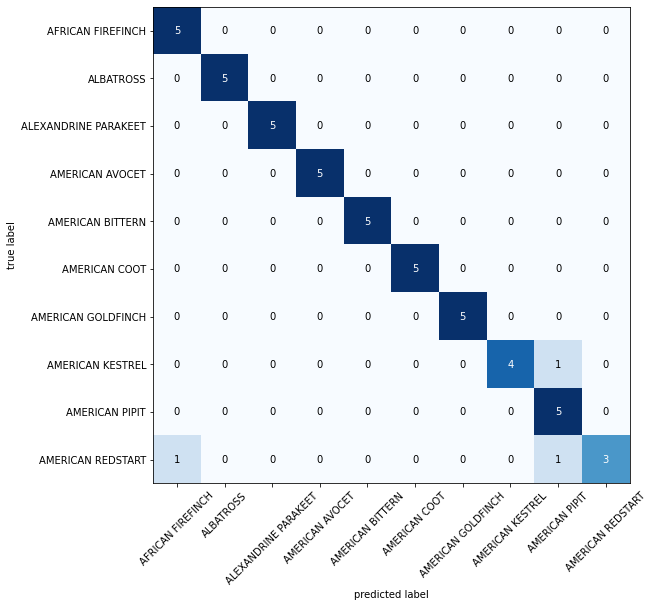

In [6]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


names = ['AFRICAN FIREFINCH','ALBATROSS','ALEXANDRINE PARAKEET','AMERICAN AVOCET','AMERICAN BITTERN',
         'AMERICAN COOT','AMERICAN GOLDFINCH','AMERICAN KESTREL','AMERICAN PIPIT','AMERICAN REDSTART']


test_data_dir = 'D:/Video Tutoriales/ImageClassification/dataset/test'  

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(width_shape, height_shape), 
    batch_size = batch_size,
    class_mode='categorical', 
    shuffle=False)

custom_Model= load_model("model_VGG16.h5")

predictions = custom_Model.predict_generator(generator=test_generator)

y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes


matc=confusion_matrix(y_real, y_pred)

plot_confusion_matrix(conf_mat=matc, figsize=(9,9), class_names = names, show_normed=False)
plt.tight_layout()

print(metrics.classification_report(y_real,y_pred, digits = 4))

In [ ]:
print(y_real)

In [ ]:
print(y_pred)